In [7]:
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split

from dataset import SyntheticTimeSeriesDataset
from model.unet import UNet1D
from model.noise_scheduler import NoiseScheduler
from model.diffusion import TimeSeriesDDPM
from model.train import train_model
from evaluation import evaluate_model

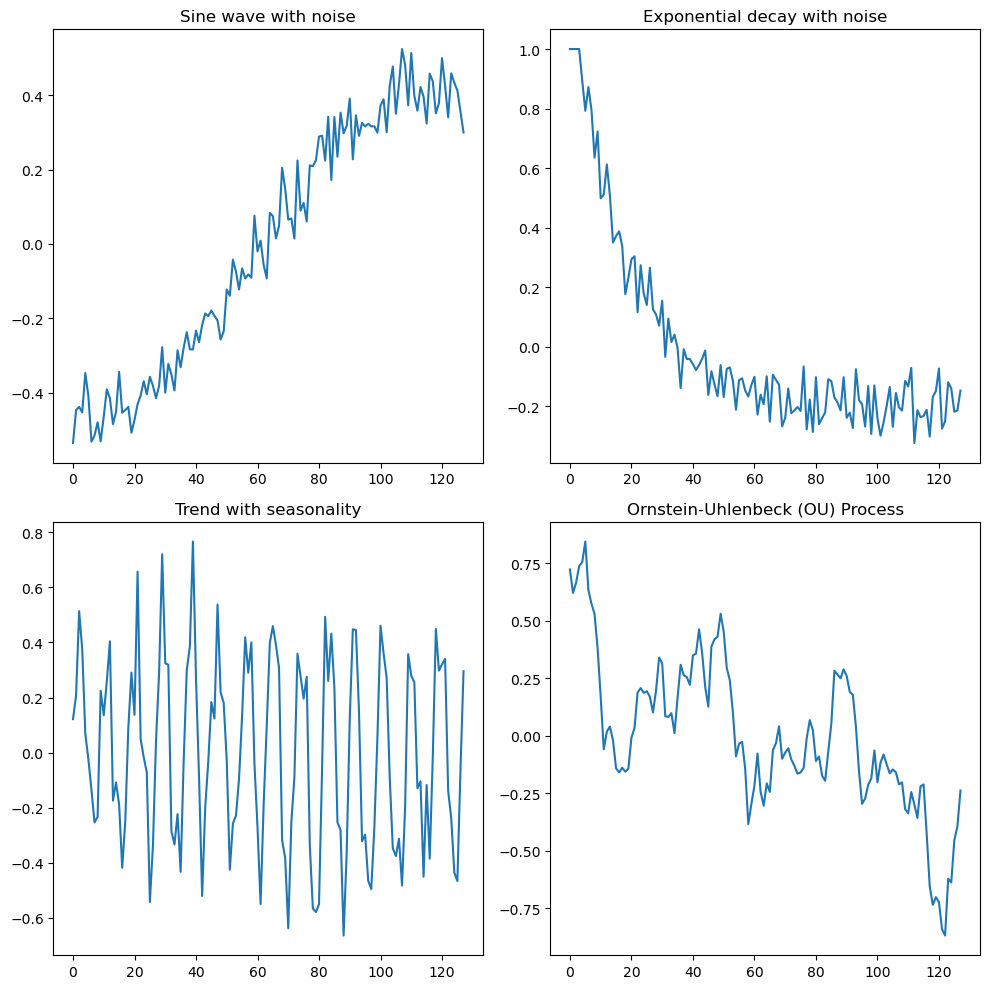

In [8]:
seq_lenght = 128
condition_lenght = 64
num_samples = 128

# Create datasets
dataset_forecast = SyntheticTimeSeriesDataset(num_samples=num_samples,
                                     seq_length=seq_lenght,
                                     condition_length=condition_lenght,
                                     task_type='forecasting')

dataset_imputation = SyntheticTimeSeriesDataset(num_samples=num_samples,
                                     seq_length=seq_lenght,
                                     condition_length=condition_lenght,
                                     task_type='imputation')

fig, axes = plt.subplots(2, 2, figsize=(10,10))
titles = [
    'Sine wave with noise',
    'Exponential decay with noise',
    'Trend with seasonality',
    'Ornstein-Uhlenbeck (OU) Process'
]

for i, ax in enumerate(axes.flatten()):
    ax.plot(dataset_forecast[i]['full_series'].numpy().flatten())
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

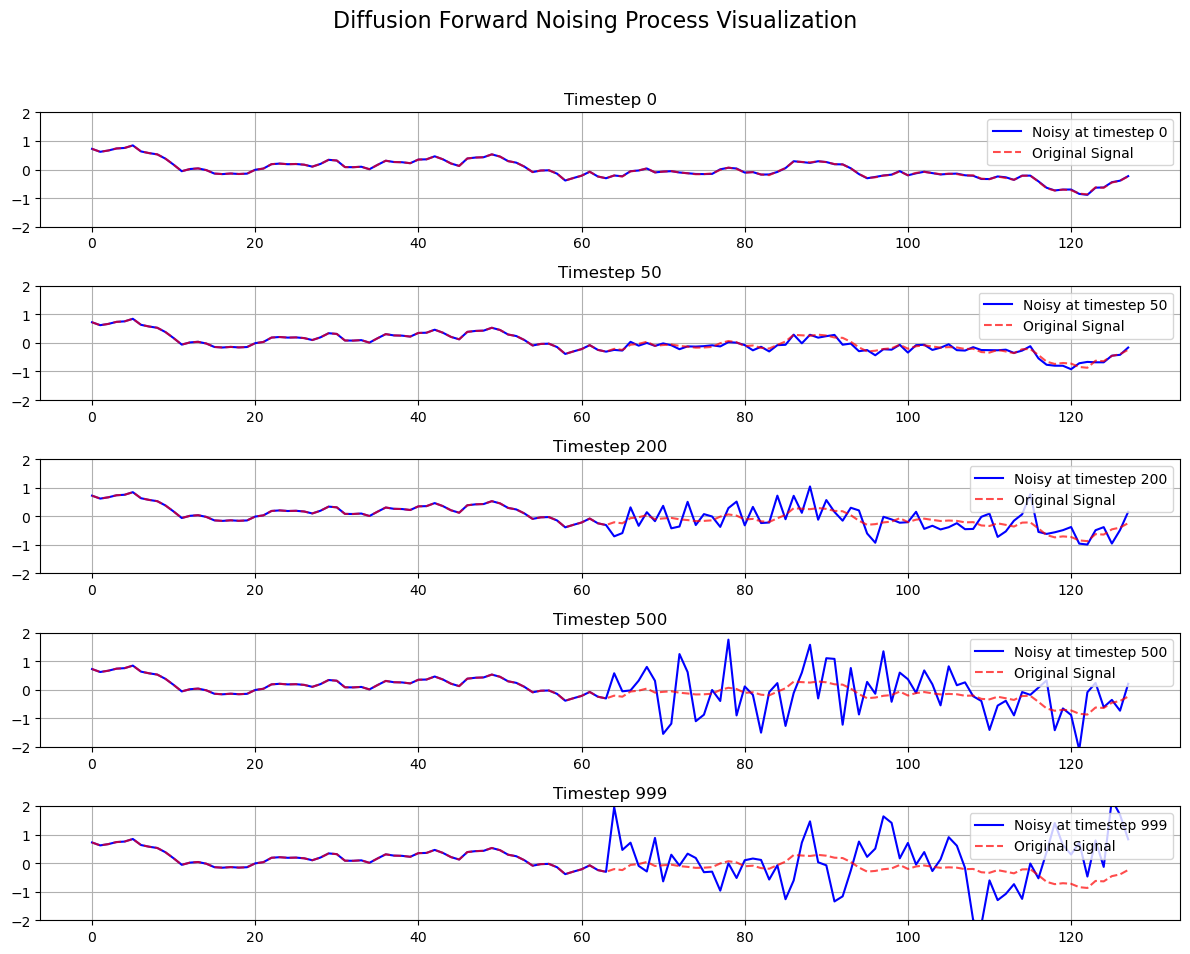

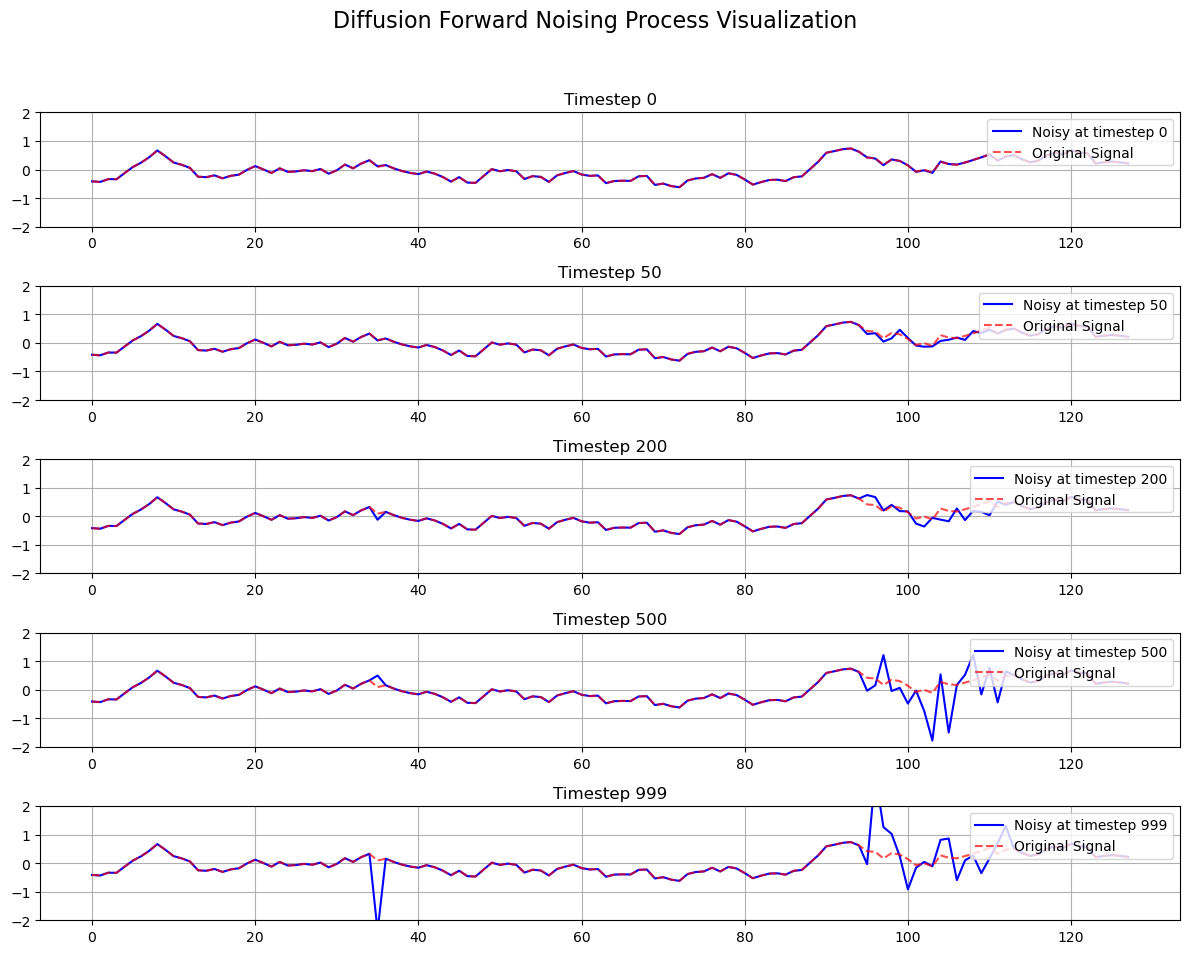

In [9]:
from util import visualize_forward_diffusion

scheduler = NoiseScheduler(num_timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule_type='cosine')

# Generate a clean synthetic 1D signal: sine wave
clean_signal = dataset_forecast[3]['full_series']
mask = dataset_forecast[3]['mask']

# Visualize noise addition for a few selected timesteps
timesteps_to_show = [0, 50, 200, 500, 999]  # from clean to very noisy

# Call the visualization function
visualize_forward_diffusion(scheduler, clean_signal, mask, timesteps_to_show)

clean_signal = dataset_imputation[3]['full_series']
mask = dataset_imputation[3]['mask']

visualize_forward_diffusion(scheduler, clean_signal, mask, timesteps_to_show)


In [10]:
batch_size = 4
dataloader = DataLoader(dataset_forecast, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
print(f"batch['full_series].shape: {batch['full_series'].shape}")
print(f"batch['condition'].shape: {batch['condition'].shape}")
print(f"batch['target'].shape: {batch['target'].shape}")
print(f"batch['mask'].shape: {batch['mask'].shape}")

batch['full_series].shape: torch.Size([4, 1, 128])
batch['condition'].shape: torch.Size([4, 1, 128])
batch['target'].shape: torch.Size([4, 1, 64])
batch['mask'].shape: torch.Size([4, 1, 128])


# Unet1D

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset and training parameters
seq_lenght = 16
condition_lenght = 8
num_samples = 8
batch_size = 4
num_epochs = 5
learning_rate = 0.001

train_ratio = 0.8
val_ratio = 1.0 - train_ratio

# Prepare train and validation dataloader
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing (train_ratio + val_ratio + test_ratio should be 1.0)

# Ensure ratios sum to 1 or adjust slightly for remainder
if not (train_ratio + val_ratio + test_ratio == 1.0):
    print("Warning: Ratios do not sum to 1.0. Adjusting test ratio to fill remainder.")
    test_ratio = 1.0 - train_ratio - val_ratio
    print(f"New test_ratio: {test_ratio:.2f}")



# Split into (Train + Validation) and Test sets
# Calculate sizes for the first split
total_size = len(dataset_forecast)
train_val_size = int(train_ratio * total_size) + int(val_ratio * total_size) # Combine train and val sizes
test_size = total_size - train_val_size # The rest goes to test

# Handle potential off-by-one from integer truncation for the final split
train_val_size = total_size - test_size




# Perform the split
train_val_dataset, test_dataset = random_split(
    dataset_forecast, [train_val_size, test_size],
    generator=torch.Generator().manual_seed(42) # For reproducibility
)


# Split the (Train + Validation) set into Train and Validation sets
new_train_ratio_in_train_val = train_ratio / (train_ratio + val_ratio)

train_size = int(new_train_ratio_in_train_val * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size # The rest goes to validation


# Perform the second split
train_dataset, val_dataset = random_split(
    train_val_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42) # Use the same seed or a different one
)

print(f"Total samples: {total_size}")
print(f"Train samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")


# --- Create DataLoaders for all three sets ---
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the denoiser architecture
arch_name = 'UNET1d'
denoiser = UNet1D(
        in_channels=1,
        out_channels=1,
        model_channels=64,
        num_res_blocks=2,
        attention_resolutions=(2, 4),
        channel_mult=(1, 2, 4),
        num_heads=4
    ).to(device)

# Initialize the noise scheduler
noise_scheduler = NoiseScheduler(num_timesteps=1000, schedule_type='linear')

# Create the Denoising Diffusion Probabilistic Model (DDPM)
ddpm_model = TimeSeriesDDPM(denoiser, noise_scheduler, device=device)

# Train the DDPM model
training_losses = train_model(
    ddpm_model,
    train_dataloader,
    val_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate)

Total samples: 128
Train samples: 88
Validation samples: 20
Test samples: 20
Denoiser model parameters: 9,737,089
Starting training for 5 epochs...
Epoch 1/5, Train Loss: 0.340336, Val Loss: 0.316253, Time: 2.63s, LR: 0.00100000
Epoch 2/5, Train Loss: 0.149671, Val Loss: 0.086925, Time: 2.79s, LR: 0.00100000
Epoch 3/5, Train Loss: 0.119214, Val Loss: 0.050861, Time: 2.61s, LR: 0.00100000
Epoch 4/5, Train Loss: 0.069071, Val Loss: 0.077829, Time: 2.61s, LR: 0.00100000
Epoch 5/5, Train Loss: 0.111383, Val Loss: 0.154937, Time: 2.58s, LR: 0.00100000


RuntimeError: Subtraction, the `-` operator, with a bool tensor is not supported. If you are trying to invert a mask, use the `~` or `logical_not()` operator instead.

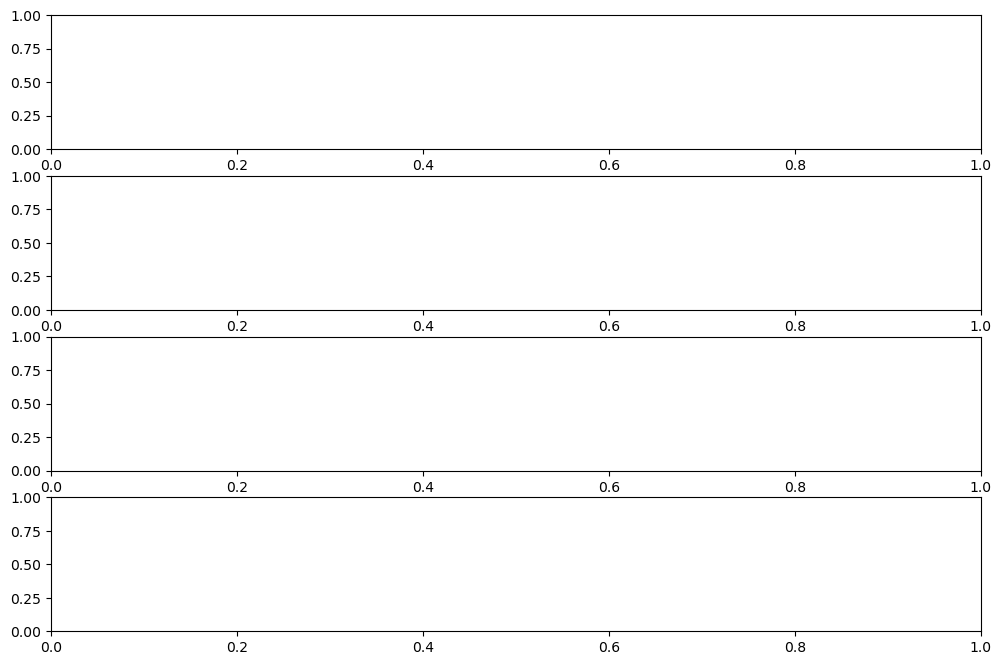

In [12]:
evaluate_model(ddpm_model, test_dataset, num_samples=4)

In [36]:
test_dataset[0]['full_series'].shape

torch.Size([1, 128])